<a href="https://colab.research.google.com/github/amazzoli/Quantitative_immunology/blob/main/notebooks/ALICE_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing the clonotype table

Here we start from a table of clonotype and we compute the generation probability of each sequence and neighbour sequences using the software OLGA, https://github.com/statbiophys/OLGA.

Notice that the notebook takes a very long time to run.
The resulting table are already saved in the repository of the course.
If you are interested in re-running everything, it takes more than one day and ~I suggest to run it on a local machine and not on colab (where unexpected disconnections can happen).


### Cloneing the repo

In [2]:
%%bash
git clone https://github.com/amazzoli/Quantitative_immunology.git

Cloning into 'Quantitative_immunology'...


### Installing the software to compute Pgen and setting it up

In [3]:
!pip install olga

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 5.5 MB/s eta 0:00:00


In [4]:
import olga.load_model as load_model
import olga.generation_probability as pgen

In [7]:
model_dir = 'Quantitative_immunology/data/'

params_file_name = model_dir + 'default_models/human_T_beta/model_params.txt'
marginals_file_name = model_dir + 'default_models/human_T_beta/model_marginals.txt'
V_anchor_pos_file = model_dir + 'default_models/human_T_beta/V_gene_CDR3_anchors.csv'
J_anchor_pos_file = model_dir + 'default_models/human_T_beta/J_gene_CDR3_anchors.csv'

In [9]:
genomic_data = load_model.GenomicDataVDJ()
genomic_data.load_igor_genomic_data(params_file_name, V_anchor_pos_file, J_anchor_pos_file)
generative_model = load_model.GenerativeModelVDJ()
generative_model.load_and_process_igor_model(marginals_file_name)
pgen_model = pgen.GenerationProbabilityVDJ(generative_model, genomic_data)

### Importing the dataset and computing Pgen

The imported dataset is a sample of a patient that got the yellow fever vaccine a few weeks before.

In [12]:
data_folder = 'Quantitative_immunology/data/'
frame = pd.read_csv(data_folder+'sequences.tsv', sep='\t', index_col=0)

In [13]:
frame

,CDR3_nt,CDR3_aa,count
0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,80952
1,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,66759
2,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,40106
3,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,34136
4,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF,22017
...,...,...,...
182146,CGATTGCAAGAGTTCTTC,RLQEFF,2
182147,TGTGCCACCGGTTCTTC,CAT_FF,2
182148,TGCGCCAGCAGTTCTTC,CAS_FF,2
182149,TGTGCCAGCAGCCCAA,CAS_AQ,2


The table has around 180k unique clonotypes.
Each of them shows the hypervariable sequence in nucleotides and the respective translation in amino-acids.
The counts are the number of istances that the clonotype has been found in the sample. For this analysis this value will not be used.

In [16]:
seq = frame.loc[0]['CDR3_aa']
pgen = pgen_model.compute_aa_CDR3_pgen(seq)
print('Pgen of ' + seq + ': ' + str(pgen))

Pgen of CASSAPAGVGEQYF: 7.367043287048197e-10


Below all the generation probabilities of all the clonotypes are computed. The command is commented to avoid that the computation starts by mistake (this operation takes several hours to be completed).
The resulting table can be imported later.

In [ ]:
def compute_pgen(row):
    # Pgen is set to zero by default for all the non-productive sequences,
    # which do not have a translation from nt to aa
    if '_' in row['CDR3_aa'] or '*' in row['CDR3_aa']:
        row['Pgen'] = 0
    else:
        row['Pgen'] = pgen_model.compute_aa_CDR3_pgen(row['CDR3_aa'])
    return row

#pgen_frame = frame.apply(compute_pgen, axis=1)

In [18]:
pgen_frame = pd.read_csv(data_folder+'sequences_pgen.tsv', sep='\t', index_col=0)
# The imported frame has less row than the original because non-productive sequences
# have been eliminated
pgen_frame

,CDR3_nt,CDR3_aa,count,Pgen
0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,80952,7.367043e-10
1,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,66759,3.048185e-10
2,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,40106,2.707978e-08
3,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,34136,1.126630e-08
4,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF,22017,1.391587e-12
...,...,...,...,...
178172,TGCGCCAGCAGCATGGGACTAGCGGGGCGAGAGACCCAGTACTTC,CASSMGLAGRETQYF,2,1.170109e-08
178173,TGCAGTGCTCGACTAGCGGGGGACCAAGAGACCCAGTACTTC,CSARLAGDQETQYF,2,1.170152e-08
178174,TGCAGTGCTCCCGGGACAGGGGCTAACTATGGCTACACCTTC,CSAPGTGANYGYTF,2,1.170543e-08
178175,TGCGCCAGCAGCTTACAGGAGCGCACAGATACGCAGTATTTT,CASSLQERTDTQYF,2,1.170883e-08


Below we lot the distribution of Pgens across the dataset, showing the huge variablity of these numbers

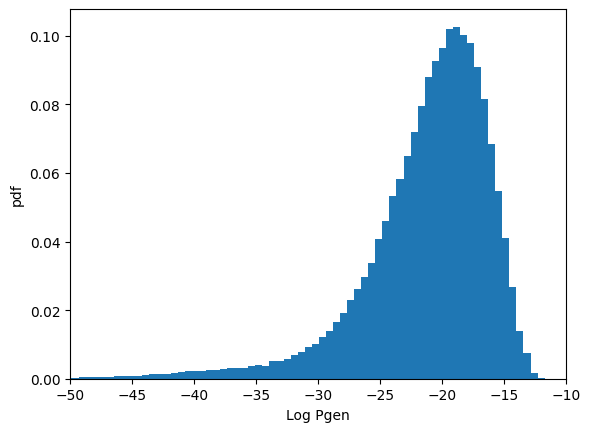

In [32]:
pgens = np.log(pgen_frame['Pgen'].values)
bins = np.linspace(min(pgens), max(pgens), 100)
plt.xlim(-50, -10)
plt.xlabel('Log Pgen')
plt.ylabel('pdf')
h = plt.hist(pgens, bins=bins, density=True)

plt.savefig('pgen_dist.png', dpi=200)

### Computing the number of neighbours

A neighbour is a sequence of the same length that has one amino-acid of difference.
To identify the neighbours in this huge dataset we ues a tool that performs the hamming distance calculation in a smart and fast way: https://github.com/statbiophys/ATrieGC

In [33]:
!pip install atriegc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for atriegc: filename=atriegc-0.0.3-cp310-cp310-linux_x86_64.whl size=1368269 sha256=871a7de8b93bb64ea864d6e912bb6cb0defb27743dce0afb7614ea5a49c5f0db
  Stored in directory: /root/.cache/pip/wheels/7d/09/7e/5d3f2397e7b4c53204a14241e0b78b806e0d96e7fe5774cae5
Successfully built atriegc


In [35]:
import atriegc

# A Trie object is created
trie = atriegc.TrieAA()
# All the amino-acid sequences are loaded
trie.insert_list(pgen_frame['CDR3_aa'])

def compute_n_neigh(row):
  # The function neighbours finds all the sequences of a given hamming distance
  # in the dataset. Here the distance is chosen to be 1
  row['n_neigh'] = len(trie.neighbours(row['CDR3_aa'], 1))
  return row

In [37]:
# This takes a few minutes to run
pgen_frame = pgen_frame.apply(compute_n_neigh, axis=1)
pgen_frame

,CDR3_nt,CDR3_aa,count,Pgen,n_neigh
0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,80952,7.367043e-10,2
1,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,66759,3.048185e-10,1
2,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,40106,2.707978e-08,3
3,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,34136,1.126630e-08,2
4,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF,22017,1.391587e-12,1
...,...,...,...,...,...
178172,TGCGCCAGCAGCATGGGACTAGCGGGGCGAGAGACCCAGTACTTC,CASSMGLAGRETQYF,2,1.170109e-08,6
178173,TGCAGTGCTCGACTAGCGGGGGACCAAGAGACCCAGTACTTC,CSARLAGDQETQYF,2,1.170152e-08,3
178174,TGCAGTGCTCCCGGGACAGGGGCTAACTATGGCTACACCTTC,CSAPGTGANYGYTF,2,1.170543e-08,1
178175,TGCGCCAGCAGCTTACAGGAGCGCACAGATACGCAGTATTTT,CASSLQERTDTQYF,2,1.170883e-08,1


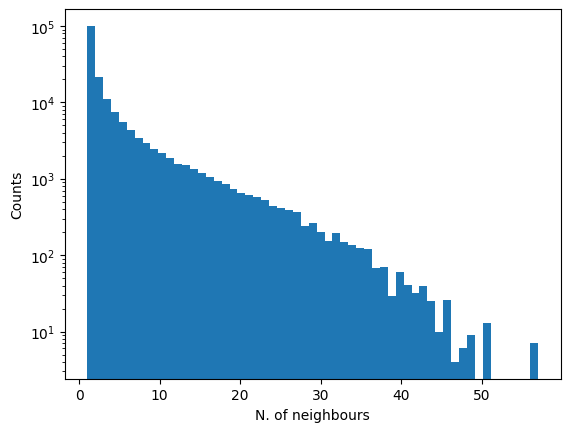

In [43]:
plt.yscale('log')
plt.xlabel('N. of neighbours')
plt.ylabel('Counts')
h=plt.hist(pgen_frame['n_neigh'], bins=max(pgen_frame['n_neigh']))

### Computing Pgen for all the neighbours of every sequence 

The next step computes the summation of Pgen of every neighbours of each sequence in the dataset.
This consumes a lot of computational resources and to speed up the process we compute this number only for the sequences with a number of neighbours larger than 2 (below it is very unlikely that they will be enriched)

In [44]:
aa_alphabet = 'RHKDESTNQCGPAVILMFYW'

def compute_l(row):
    
    # Avoiding the computation for N neighbours smaller than 2
    if row['n_neigh'] <= 2:
        row['Pgen_neigh'] = 0
        return row
    
    ref = row['CDR3_aa']
    sum_pgen = 0
    # Iteration over all the letters in the sequence
    for i in range(len(ref)):

      # Iteration over all the possible aminoacid
        for new_aa in aa_alphabet:

            # From string to list
            neigh = list(ref)

            # Skipping the same letter of the sequence
            if new_aa == neigh[i]:
              continue

            # Changing the letter and re-casting to a string
            neigh[i] = new_aa
            neigh = "".join(neigh)
            
            sum_pgen += pgen_model.compute_aa_CDR3_pgen(neigh)

    row['Pgen_neigh'] = sum_pgen
    
    return row

In [47]:
# Again the actual computation is commented
#pgen_frame = pgen_frame.apply(compute_l, axis=1)

The result can be loaded

In [49]:
pgen_frame = pd.read_csv(data_folder+'sequences_pgen_neigh.tsv', sep='\t', index_col=0)
pgen_frame

,CDR3_nt,CDR3_aa,Pgen,n_neigh,Pgen_neigh
0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF,7.367043e-10,2,0.000000e+00
1,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF,3.048185e-10,1,0.000000e+00
2,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,2.707978e-08,3,1.909027e-06
3,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF,1.126630e-08,2,0.000000e+00
4,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF,1.391587e-12,1,0.000000e+00
...,...,...,...,...,...
178172,TGCGCCAGCAGCATGGGACTAGCGGGGCGAGAGACCCAGTACTTC,CASSMGLAGRETQYF,1.170109e-08,6,1.087258e-06
178173,TGCAGTGCTCGACTAGCGGGGGACCAAGAGACCCAGTACTTC,CSARLAGDQETQYF,1.170152e-08,3,4.471216e-07
178174,TGCAGTGCTCCCGGGACAGGGGCTAACTATGGCTACACCTTC,CSAPGTGANYGYTF,1.170543e-08,1,0.000000e+00
178175,TGCGCCAGCAGCTTACAGGAGCGCACAGATACGCAGTATTTT,CASSLQERTDTQYF,1.170883e-08,1,0.000000e+00
